# Exercise 1: Image Compression

**Covered Topics: Lecture 3**

You are organizing a tic-tac-toe championship with your friends, where all the games will be played on a gaming console, i.e. on a digital board. Due to the wide interest in the championship, you want to share the live games on internet. Thus, you plan to record the games using an external camera, and transmit it. Your friend from mechanical engineering has already agreed to help you with the camera setup. Unfortunately, being a poor student, you can only afford a cheap camera which provides you noisy images. To make the matter worse, your internet connection is poor and hence you cannot transmit the full images directly due to large file size. Thankfully, you are currently taking a computer vision course :) Thus you decide to use your newly acquired knowledge to design a software which can i) compress the images obtained from the camera for efficient transmission, and ii) reconstruct the compressed images on the client side to generate a high quality, noise free, output. An overview of the entire pipeline is shown in Figure.

![](https://drive.google.com/uc?export=view&id=1GSONZLYDWt0OxmbzdVNIXR8evSSTODco)

**Details about the setup**
* The camera is placed exactly about the console screen. Both the console, and the camera are rigidly placed, i.e. they do not move. Furthermore, the screen is always fully visible in the camera and we do not have any other object, e.g. hand entering the camera view.
* The actual game image $x$ (the one displayed on the console screen) is a discrete RGB image of size 96 x 96. Each pixel in the image is an integer which can take values between [0, 255]. In fact, the pixels at each location in the image can take only one of 4 values, white for the background region, black for the grid lines, red for the X sign, and green for the O sign.
* The camera provides you an RGB image $\hat{x}$ of size 96 x 96 which is corrupted by noise. Each pixel in the image is a 32-bit floating-point number which can take any continuous value between [0.0, 255.0].  Note that due to the presence of noise, the pixels in the camera image can take any continuous value, even though pixels in the original image only have discrete integral values.


In order to design your compression algorithm, you have access to a dataset $\mathcal{D}_{train} = \{\hat{x}_i\}_{i=1}^{100}$ containing 100 noisy images captured using the exact same camera setup. You can use this dataset to learn codebook $\mathcal{C}$ which you use for compression. For instance, if you use Principal Component Analysis (PCA) approach for compression, the codebook $\mathcal{C}$ will contain the first $K$ principal components, as well as the mean image. Given a new image $\hat{x}_j$ from a game, and the learnt codebook $\mathcal{C}$, your compression algorithm should output a compressed representation $z_j = \texttt{Compress}(\hat{x}_j, \mathcal{C})$, which is smaller in size compared to $\hat{x}_j$. Finally, you should also provide a reconstruction algorithm which can recover an estimate $x^{pred}_j = \texttt{Reconstruct}(z_j, \mathcal{C})$ of the **original** clean image $x_j$ given the compressed version $z_j$ and the codebook $\mathcal{C}$.

For debugging purposes, we also provde a validation dataset containing 50 noisy images, as well as the clean ground truth for each of these images.

**Evaluation Criteria**

Your method will be evaluated using three criterias, namey the size of the codebook, the compression ability and the reconstruction quality. For evaluation, you are provided with a test dataset $\mathcal{D}_{test} = \{\hat{x}_j\}_{j=1}^{50}$ containing 50 noisy images. Your method should output i) the compressed representations $z_j$ for each of the test images, ii) the codebook $\mathcal{C}$ employed for compression, and iii) the reconstructed version $x^{pred}_j$ for each of the test images. **Note** that both your codebook $\mathcal{C}$, as well as the compressed representations $z_j$ are **required** to be Numpy arrays. The codebook size, the mean compressed size, and the mean reconstruction error are then computed as follows,

$$ \text{CodebookSize} = \texttt{Size}(\mathcal{C})$$
$$ \text{MeanCompressedSize} = \frac{1}{50}\sum_{j=1}^{50} \texttt{Size}(z_j) $$
$$ \text{MeanReconError} = \frac{1}{100}\sum_{j=1}^{100} \|x^{pred}_j - x_j\|_2 $$

Here, $\|.\|_2$ denotes the $\mathcal{L}_2$ norm. That is, it computes the root mean squared error between the pixel values of predicted image and the ground truth image over the full image. The $\texttt{Size}$ function computes the size of the input NumPy arrays based on their shape and data types, in terms of bytes. For instances, if your codebook $\mathcal{C}$ is a Numpy array of datatype $\texttt{uint8}$ and shape $50 \times 50 \times 3$, then $\texttt{Size}(\mathcal{C}) = 50*50*3*1$. Please refer to the evaluation script included in this notebook (`evaluation.py`) for more details.

The final evaluation score is obtained as the weighted sum of each of these individual scores,

$$ \text{EvaluationScore} = \text{MeanReconError} + \frac{1}{10^6}\text{CodebookSize} + \frac{1}{10}\text{MeanCompressedSize} $$

**Passing requirement**

To pass this exercise your EvaluationScore has to be lower than the score submitted by IACV_BASELINE to the evaluation server.
The link to the evaluation server can be found on Moodle.

## Initialize the environment and load data
Import the necessary libraries. Note that you are **NOT** allowed to use any additional libraries

In [1]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import os
import sys
import random
from pathlib import Path


import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline


**TODO:** Set the path in Google drive where you uploaded the handout, e.g. My Drive/iacv/ex1

In [2]:
# iacv_path = '/Users/mahmoudelminawi/Desktop/ETH_projects/IACV/handout/handout.ipynb'
env_path = Path('.') #/ iacv_path
data_path = env_path / 'data'

# Add the handout folder to python paths
if str(env_path) not in sys.path:
    sys.path.append(str(env_path))

# Import evaluation package
import eval_utils

Helper functions to load and display images. You do not need to modify these functions.

In [3]:
def load_image(im_path):
    """
        This function loads an image from file and returns it as NumPy array.
        The NumPy array will have shape Height x Witdh x Channels and data of type unit8 in the range [0, 255]
    """
    im = Image.open(im_path)
    return np.asarray(im)

def show_images(ims, titles=None):
    """ Plot a list of images """
    N = len(ims)
    fig, ax = plt.subplots(1, N)

    for id, im in enumerate(ims):

        # Check correct data type and range
        if np.issubdtype(im.dtype, np.floating):
            assert im.min() >= 0.0 and im.max() <= 1.0, \
                "Images with floating dtype are expected to be within [0, 1]"

        ax[id].imshow(im)

        if titles is not None:
            ax[id].set_title(titles[id])

    plt.show()

Load the training, validation, and test images into python dictionaries.</br>
The dict keys will be file names (e.g. '010') - the values will be the images as numpy arrays.</br>
This may take some time (a few minutes).

In [4]:
print("Loading train images")
train_path = data_path / 'train_n'
train_images = {f.stem: load_image(str(f)) for f in train_path.glob('*.png')}

print("Loading test images")
test_path = data_path / 'test_n'
test_images = {f.stem: load_image(str(f)) for f in test_path.glob('*.png')}

print("Loading val images")
val_path = data_path / 'val_n'
val_images = {f.stem: load_image(str(f)) for f in val_path.glob('*.png')}

print("Loading val ground truths")
val_path_c = data_path / 'val_c'
val_gt = {f.stem: load_image(str(f)) for f in val_path_c.glob('*.png')}

Loading train images
Loading test images
Loading val images
Loading val ground truths


Visualize a few validation images, along with ground truth to get an idea of how the images look. You can run this cell multiple times to visualize different images.

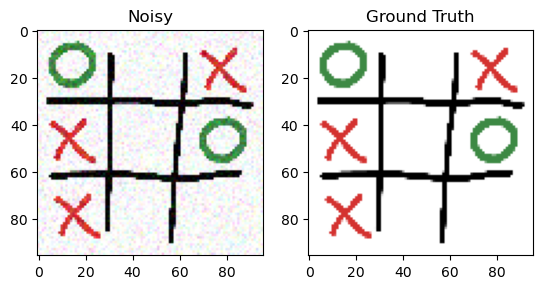

In [5]:
key = random.choice(list(val_gt.keys()))
show_images([val_images[key], val_gt[key]], ['Noisy', 'Ground Truth'])

## Implement your solution

**TODO:** You are provided with a simple implementation of the `ImageCompressor` and `ImageReconstructor` classes (image_compressor.py). The `ImageCompressor` class is used to learn the codebook, and obtain compressed representation of input images, while the `ImageReconstructor` class decodes the compressed representation to generate the output image. Modify these classes to include your compression and reconstruction algorithms. **Note:** You are not allowed to use any external packages except NumPy in `image_compressor.py`. Otherwise your submission will crash on the Evaluation server.

**Important:** The next cells demonstrate how the two classes will be used. Have a look at them before implementing your approach.


## Test your solution on validation set

Test your algorithm on some validation images and visualize the output. First, we initialize the ImageCompressor object and learn the codebook.

**Important:** Don't forget to import the `image_compressor` every time you modify the `image_compressor.py` file, otherwise your latest changes won't be loaded.

In [8]:
# Import the image_compressor class everytime you modify image_compressor.py file.
# Otherwise your changes won't be loaded
from image_compressor import ImageCompressor, ImageReconstructor

# Initialize the compressor object and learn the codebook
compressor = ImageCompressor()
compressor.train(list(train_images.values()))

# get the learnt codebook
codebook = compressor.get_codebook()

# Initialize the reconstructor (This will be done on the server side)
reconstructor = ImageReconstructor(codebook)

stacked_images shape: (100, 96, 96, 3)
stacked_images shape: (100, 27648)
mean shape: (1, 27648)
demeaned: (100, 27648)
(100, 27648)
U shape: (27648, 100)
U compressed: (27648, 25)
mean shape:
(1, 27648)
compressed U shape:
(27648, 25)
codebook shape (26, 27648)


In [9]:
reconstructor.codebook.shape

(26, 27648)

Next, try reconstructing a few validation images and visualize results. We also print the evaluation scores. You are encouraged to check the evaluation code provided at evaluation.py. However you shouldn't modify the evaluation script.

test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
[[0.9766 0.965  0.9653 ... 0.96   0.965  0.97  ]]
(1, 27648)


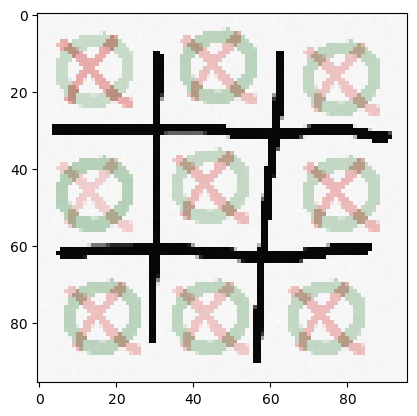

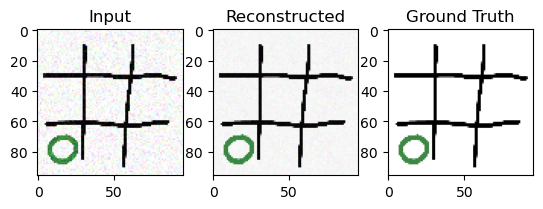

mean shape:
(1, 27648)
compressed U shape:
(27648, 25)
codebook shape (26, 27648)
Evaluation Score is: 15.828

Weighted Reconstruction Error is: 9.390
Weighted Compressed Image Size is: 5.0
Weighted Codebook size is: 1.4376959999999999


In [17]:
key = random.choice(list(val_gt.keys()))

img_in = val_images[key]
img_gt = val_gt[key]
img_compressed = compressor.compress(img_in)

img_rec = reconstructor.reconstruct(img_compressed)

from matplotlib import pyplot as plt
plt.imshow(compressor.mean.reshape((96,96,3)))
show_images([img_in, img_rec, img_gt], ['Input', 'Reconstructed', 'Ground Truth'])

rmse = eval_utils.compute_rmse(img_rec, img_gt)
img_code_size = img_compressed.nbytes
codebook_size = compressor.get_codebook().nbytes
w_score, w_rmse, w_img_code_size, w_codebook_size = eval_utils.weight_scores(
    rmse, img_code_size, codebook_size
)

print(f'Evaluation Score is: {w_score:0.3f}')
print()
print(f'Weighted Reconstruction Error is: {w_rmse:0.3f}')
print(f'Weighted Compressed Image Size is: {w_img_code_size}')
print(f'Weighted Codebook size is: {w_codebook_size}')

Once your are happy with your implementation, you can test on the full validation set to obtain the evaluation score. **Important:** Ensure that you can execute the next cell without any errors to compute the evaluation score.

In [ ]:
from image_compressor import ImageCompressor, ImageReconstructor

# Learn the compressor
compressor = ImageCompressor()
compressor.train(list(train_images.values()))

# Compress all images
img_code = {k: compressor.compress(v) for k, v in val_images.items()}

codebook = compressor.get_codebook()

# Init reconstructor - will be done on server side
reconstructor = ImageReconstructor(codebook)

eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)

print(f'Evaluation Score is: {eval_score:0.3f}')
print(f'Mean Reconstruction Error is: {recon_error:0.3f}')
print(f'Mean Compressed Image Size is: {compressed_im_size}')
print(f'Codebook size is: {codebook_size}')

stacked_images shape: (96, 96, 3, 100)
stacked_images shape: (27648, 100)
mean shape: (27648, 1)
demeaned: (27648, 100)
(27648, 100)
U shape: (27648, 100)
U compressed: (27648, 25)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 2

## Generate the final submission on the test set

After finishing your implementation, you can run the next cell to generate the results, which will be stored in the submission directory on your Google Drive. This cell saves the compressed representation of each test image, the learnt codebook, as well as your implementation of the `image_compressor.py` to the submission directory. Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server (https://codalab.lisn.upsaclay.fr/competitions/7754) to obtain the scores on the test set.


In [ ]:
from image_compressor import ImageCompressor
import shutil

compressor = ImageCompressor()
compressor.train(list(train_images.values()))

out_dir = env_path / 'submission'
out_dir.mkdir(exist_ok=True)

for img_id, img in test_images.items():
    img_code = compressor.compress(img)
    np.save(out_dir / f'{img_id}.npy', img_code)

codebook = compressor.get_codebook()
np.save(out_dir / 'codebook.npy', codebook)

shutil.copyfile(env_path / 'image_compressor.py', out_dir / 'image_compressor.py')

stacked_images shape: (96, 96, 3, 100)
stacked_images shape: (27648, 100)
mean shape: (27648, 1)
demeaned: (27648, 100)
(27648, 100)
U shape: (27648, 100)
U compressed: (27648, 25)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 27648)
z size (25, 1)
test image (96, 96, 3)
test image reshape (27648, 1)
test image expand (96, 96, 3, 1)
utrans (25, 2

PosixPath('submission/image_compressor.py')